In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.externals import joblib

from moviepy.editor import VideoFileClip, concatenate_videoclips
from IPython.display import HTML

%matplotlib inline

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Get hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    features = hog(img, orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block),
                    block_norm= 'L2-Hys',
                    transform_sqrt=True, 
                    visualise=vis, feature_vector=feature_vec)
    return features


# get hog features for all image channels
def get_hog_feature_all_channels(img, orient, pix_per_cell, cell_per_block):
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    hf_ch1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hf_ch2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hf_ch3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    return hf_ch1, hf_ch2, hf_ch3


In [3]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def get_windows(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = img.shape[0]//2
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            #cv2.rectangle(img, (startx, starty), (endx, endy), (0,0,255), 4)
    # Return the list of windows
    return window_list

In [4]:
class Window:
    def __init__(self):
        self.windows = []
        self.hog_features = None
        self.predictions = []
        self.hot_indexes = []

# get prediction for each window
def get_predictions(classifier, Xscaler, img, window_data, y_start_pos, x_start_pos, cell_per_block, pix_per_cell,
                    inc_spatial, inc_hist, spatial_size = (32, 32), hist_bins = 32, hist_range = (0, 256)):
    predictions = []
    hog_features = window_data.hog_features
    all_windows = window_data.windows
    hog_f1 = hog_features[0]
    hog_f2 = hog_features[1]
    hog_f3 = hog_features[2]
    # loop over windows to get features for
    for i in range(len(all_windows)):
        win_features = []
        # image patch for which to get features
        win = all_windows[i].astype(int)
        tlt, brt = win
        img_win = np.copy(img[tlt[1]:brt[1], tlt[0]:brt[0]])
        img_win = cv2.resize(img_win, (64, 64))
        # get spatial features
        if inc_spatial:
            spf = bin_spatial(img_win, size=spatial_size)
            win_features.append(spf)
        # get color histogram features
        if inc_hist:
            hsf = color_hist(img_win, nbins=hist_bins, bins_range=hist_range)
            win_features.append(hsf)
        # get hog features
        hxs = int((tlt[0] - x_start_pos)//pix_per_cell)    #cell no. equals block no.
        hys = int((tlt[1] - y_start_pos)//pix_per_cell)
        hxe = int((brt[0] - x_start_pos)//pix_per_cell) - cell_per_block + 1   #total blocks in window range
        hye = int((brt[1] - y_start_pos)//pix_per_cell) - cell_per_block + 1
        
        # check for proper shape, modify 6 to calculation with parameters
        shp = hog_f1[hys:hye, hxs:hxe].shape
        if shp[0] != shp[1] or shp[0] < 6:
            predictions.append(0)
            continue
        if hxe > hog_f1.shape[1] or hye > hog_f1.shape[0]:
            predictions.append(0)
            continue
        hog_ch1 = hog_f1[hys:hye, hxs:hxe].ravel()
        hog_ch2 = hog_f2[hys:hye, hxs:hxe].ravel()
        hog_ch3 = hog_f3[hys:hye, hxs:hxe].ravel()
        #print(hys, hye, hxs, hxe, hog_f1[hys:hye, hxs:hxe].shape)
        hgf = np.hstack((hog_ch1, hog_ch2, hog_ch3))
        win_features.append(hgf)
        #features.append(win_features)
        #print(win_features[0].shape, win_features[1].shape, win_features[2].shape, x_start_pos)
        test_features = Xscaler.transform(np.hstack(win_features).reshape(1, -1))
        predictions.append(classifier.predict(test_features))
    return np.array(predictions)

def cool_heat(hot_img, threshold):
    hot_img[hot_img <= threshold] = 0
    return hot_img
    
# find cars in given image by using the given trained classifier
def find_cars(img, classifier, Xscaler, orient, pix_per_cell, cell_per_block, spatial, hbins, overlap):
    global hot_frames
    hot_img = np.zeros(img[:,:,0].shape)
    hot_img.astype(np.int)
    # multi-window sizes, multiples of hog cell size to ease custom feature extraction
    trained_win_size = 64
    win_sizes = [72]
    # y-axis scan range
    h, w = img.shape[0:2]
    y_fullrange_img = [((h//2)//64)*64, h-48]
    #print(y_fullrange_img)
    y_len = y_fullrange_img[1] - y_fullrange_img[0]
    # range_offsets along x-axis for each window
    x_offset = [0]
    # range_offsets along y-axis for each window
    y_offset = [0]
    # list of windows for each window size
    all_windows = {72:Window()}
    
    # convert to YUV colorspace
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #print(img.shape)
    # find boxes and hog features for entire area to be scanned for each window size
    for i in range(len(win_sizes)):
        #print("start again")
        features = []
        # scan range for y-axis
        y_range_img = [y_fullrange_img[0] + y_offset[i], y_fullrange_img[1] - y_offset[i]]
        # get x range for search
        x_range_img = [x_offset[i]+(7*w//16), image.shape[1] - x_offset[i]]
        # get all the windows in this range
        all_windows[win_sizes[i]].windows = get_windows(img, x_start_stop=x_range_img, y_start_stop=y_range_img, 
                                        xy_window=(win_sizes[i], win_sizes[i]), xy_overlap=(overlap, overlap))
        # resize the image so that current window size scales to 64x64 px, i.e, the size of images in training data
        scale = trained_win_size/win_sizes[i]
        # image patch for which to get hog features
        window_clip = np.copy(img[y_range_img[0]:y_range_img[1]+1, x_range_img[0]:x_range_img[1]+1])
        # resize to scale to window size of 64x64 px
        #print(win_sizes[i], y_range_img, window_clip.shape, scale)
        window_clip = cv2.resize(window_clip, (int(window_clip.shape[1]*scale), int(window_clip.shape[0]*scale)))
        res_img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))
        scaled_ystart = y_range_img[0]*scale
        scaled_xstart = x_range_img[0]*scale
        # get hog features for the entire patch
        all_windows[win_sizes[i]].hog_features = get_hog_feature_all_channels(window_clip, orient, pix_per_cell, cell_per_block)
        #print(y_range_img, x_range_img, len(all_windows[win_sizes[i]].windows))
        #print(all_windows[win_sizes[i]].hog_features[0].shape)
        # scale the windows
        all_windows[win_sizes[i]].windows = np.asarray(all_windows[win_sizes[i]].windows)*scale
        # get predictions for the searched windows
        all_windows[win_sizes[i]].predictions = get_predictions(classifier, Xscaler, res_img, all_windows[win_sizes[i]],
                                                        scaled_ystart, scaled_xstart, cell_per_block,
                                                        pix_per_cell, inc_spatial=True, inc_hist=True,
                                                        spatial_size = (spatial, spatial),
                                                        hist_bins = hbins, hist_range = (0, 256))
        # scale back windows to original size
        all_windows[win_sizes[i]].windows = np.asarray(all_windows[win_sizes[i]].windows)//scale
        all_windows[win_sizes[i]].windows = all_windows[win_sizes[i]].windows.astype(int)
        
        # get indexes on non-zero(car) predictions
        all_windows[win_sizes[i]].hot_indexes = np.array((all_windows[win_sizes[i]].predictions.nonzero())[0])
        # add heat to hot_img
        #print(all_windows[win_sizes[i]].hot_indexes)
        for ind in all_windows[win_sizes[i]].hot_indexes:
            # get corners x-y from hot windows
            tlt, brt = all_windows[win_sizes[i]].windows[ind]
            #weights proportional to size of the window
            hot_img[tlt[1]:brt[1]+1, tlt[0]:brt[0]+1] = hot_img[tlt[1]:brt[1]+1, tlt[0]:brt[0]+1] + 2 #(2*(5-i))
    #print(np.max(hot_img))
    #nhot_img = hot_img
    # weighted average hot_img across 10 older frames
    nhot_img = np.zeros_like(hot_img)
    nhot_img.astype(np.int)
    fln = len(hot_frames)
    #ttl = int((fln+1)*(fln+2)/2)
    for i in range(fln):
        nhot_img = nhot_img + hot_frames[i]
    nhot_img = (nhot_img + hot_img)#//(fln+1)
    #print(np.max(nhot_img))
    # remove unwanted heat by thresholding
    nhot_img = cool_heat(nhot_img, 14*(fln+1))
    # normalize the heat
    nhot_img = (nhot_img/np.max(nhot_img))*255
    nhot_img.astype(np.uint8)
    nhot_img = cv2.GaussianBlur(nhot_img, (3,3), 0)
    # remove unwanted heat by thresholding
    #nhot_img = cool_heat(nhot_img, 125)
    # add frame to buffer
    hot_frames.append(cool_heat(hot_img, 12))
    if len(hot_frames) > 30:
        hot_frames.pop(0)
    #plt.imshow(nhot_img)
    #plt.show()
    return nhot_img

def draw_labeled_bboxes(img, labels):
    h, w = img.shape[:2]
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if 2*w//8 >= abs(bbox[0][0]-bbox[1][0]) >= 50 and abs(bbox[0][1]-bbox[1][1]) >= 40:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def process_image(img):
    global svc, X_scaler
    
    # hog cell details
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    spatial = 16
    hbins = 32
    overlap = 0.875
    
    heat_map = find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, hbins, overlap)
    labels = label(heat_map)
    op = draw_labeled_bboxes(img, labels)
    mini_hm = cv2.resize(heat_map, (360, 240))
    mini_hm = np.dstack((mini_hm, np.zeros_like(mini_hm), np.zeros_like(mini_hm)))
    op[0:240, op.shape[1]-360:op.shape[1]] = mini_hm
    return op

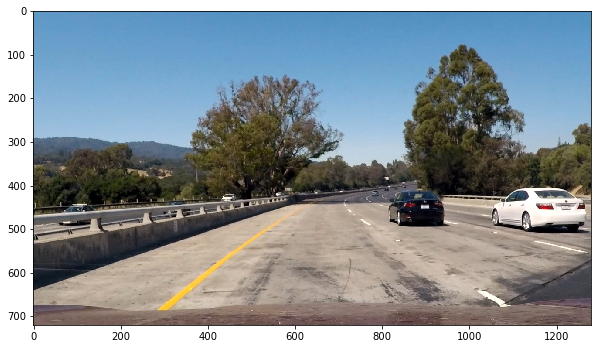

Time taken to predict: 1.37 seconds


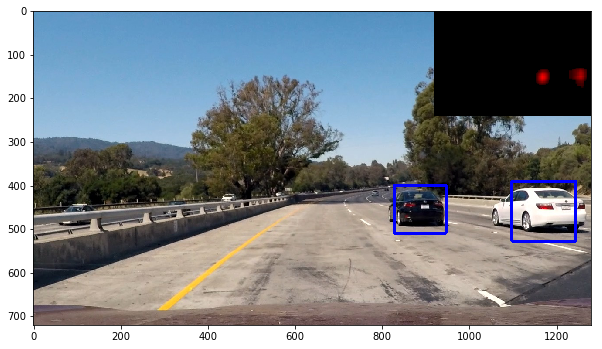

In [5]:
svc = joblib.load('svm_model.pkl')
X_scaler = joblib.load('svm_scaler.pkl')

hot_frames = []
n = 1
image = cv2.imread('./test_images/test'+str(n)+'.jpg')
image = cv2.resize(image, (1280, 720))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.show()

t0 = time.time()
op = process_image(image)
t1 = time.time()
print("Time taken to predict:", round((t1-t0), 2),"seconds")
plt.figure(figsize=(10, 6))
plt.imshow(op)
plt.show()

In [6]:
hot_frames = []

output_vid = './output_videos/test_video.mp4'
in_clip = VideoFileClip("test_video.mp4")

output_clip = in_clip.fl_image(process_image)
#%time output_clip.write_videofile(output_vid, audio=False)

In [ ]:
HTML("""
<video style='width:960px;height:540px' controls>
  <source src="{0}">
</video>
""".format('./output_videos/test_video.mp4'))

In [ ]:
hot_frames = []

output_vid = './output_videos/project_video.mp4'
in_clip = VideoFileClip("project_video.mp4").subclip(20, 30)

output_clip = in_clip.fl_image(process_image)
%time output_clip.write_videofile(output_vid, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


 11%|████████▋                                                                        | 27/251 [00:37<05:14,  1.40s/it]

In [ ]:
HTML("""
<video style='width:960px;height:540px' controls>
  <source src="{0}">
</video>
""".format('./output_videos/project_video.mp4'))

In [ ]:
from tqdm import tqdm_notebook
from time import sleep
# works on any iterable, including cursors. 
# for iterables with len(), no need to specify 'total'.
for i in range(100):
    sleep(0.05)
    print("\r"+("|"*i)+(" "*(100-i))+str(i+1)+"%", end="")
